# Multi-Day Timeseries and Summary Grids

This tutorial runs a 4-day SOLWEIG timeseries over the Athens demo area and explores the
summary products: aggregated grids, timeseries plots, and the text report.

`calculate()` carries thermal state (ground and wall temperatures) between
timesteps, so results are more accurate than looping over single-timestep calls manually.


In [ ]:
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import solweig
from pyproj import CRS

DATA_DIR = Path("demos/data/athens")
WORK_DIR = Path("temp/tutorial_cache")
WORK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR = WORK_DIR / "output_timeseries"

assert (DATA_DIR / "DSM.tif").exists(), f"Demo data not found at {DATA_DIR.resolve()}"

EXTENTS_BBOX = [476800, 4205850, 477200, 4206250]
TARGET_CRS = 2100

## 1. Prepare the surface

If you ran the [Quick Start](01-athens-quickstart.ipynb) tutorial, the cached SVF and wall
data in `working_dir` will be reused automatically.


In [ ]:
# Rasterise tree vectors (or reuse saved CDSM)
cdsm_path = WORK_DIR / "CDSM.tif"
if not cdsm_path.exists():
    trees_gdf = gpd.read_file(str(DATA_DIR / "trees.gpkg")).to_crs(TARGET_CRS)
    cdsm_rast, cdsm_transf = solweig.io.rasterise_gdf(
        trees_gdf,
        "geometry",
        "height",
        bbox=EXTENTS_BBOX,
        pixel_size=1.0,
    )
    solweig.io.save_raster(
        str(cdsm_path),
        cdsm_rast,
        cdsm_transf.to_gdal(),
        CRS.from_epsg(TARGET_CRS).to_wkt(),
    )

surface = solweig.SurfaceData.prepare(
    dsm=str(DATA_DIR / "DSM.tif"),
    working_dir=str(WORK_DIR / "working"),
    cdsm=str(cdsm_path),
    bbox=EXTENTS_BBOX,
    pixel_size=1.0,
)
print(f"Surface ready: {surface.dsm.shape}")

INFO:solweig.models.surface:Preparing surface data from GeoTIFF files...
INFO:solweig.io:No-data value is -9999.0, replacing with NaN
INFO:solweig.models.surface:  DSM: 400×400 pixels
INFO:solweig.models.surface:  Using specified pixel size: 1.00 m
INFO:solweig.models.surface:  CRS validated: GGRS87 / Greek Grid (EPSG:2100)
INFO:solweig.io:No-data value is -9999.0, replacing with NaN
INFO:solweig.models.surface:  ✓ Canopy DSM (CDSM) provided
INFO:solweig.models.surface:  → No TDSM provided - will auto-generate from CDSM (ratio=0.25)
INFO:solweig.models.surface:Checking for preprocessing data...
INFO:solweig.io:No-data value is -9999.0, replacing with NaN
INFO:solweig.io:No-data value is -9999.0, replacing with NaN
INFO:solweig.models.surface:  ✓ Walls found in working_dir: temp/tutorial_cache/working/walls/px1.000
INFO:solweig.models.surface:  ✓ SVF loaded from memmap (memory-efficient)
INFO:solweig.models.surface:  ✓ SVF found in working_dir: temp/tutorial_cache/working/svf/px1.000
IN

Surface ready: (400, 400)


## 2. Load 4 days of weather


In [4]:
epw_path = str(DATA_DIR / "athens_2023.epw")
weather_list = solweig.Weather.from_epw(epw_path, start="2023-07-01", end="2023-07-04")
location = solweig.Location.from_epw(epw_path)

print(f"{len(weather_list)} hourly timesteps")
print(f"Date range: {weather_list[0].datetime} → {weather_list[-1].datetime}")

INFO:solweig.io:Loaded EPW file: NA, 8760 timesteps (pure Python parser)
INFO:solweig.models.weather:Loaded 96 timesteps from EPW: 2023-07-01 00:00 → 2023-07-04 23:00
INFO:solweig.models.weather:Location from EPW: NA — 38.0000°N, 23.7500°E (UTC+2, 175m)


96 hourly timesteps
Date range: 2023-07-01 00:00:00 → 2023-07-04 23:00:00


## 3. Run the timeseries

We save Tmrt and shadow GeoTIFFs to disk and also use the anisotropic sky model for better accuracy.


In [5]:
summary = solweig.calculate(
    surface=surface,
    weather=weather_list,
    location=location,
    use_anisotropic_sky=True,
    output_dir=str(OUTPUT_DIR),
    outputs=["tmrt", "shadow"],
)

INFO:solweig.tiling:Resource-aware tile sizing (context=solweig): GPU max_buffer=9,534,832,640 bytes, system RAM=17,179,869,184 bytes, max_tile_side=4634 px
[GPU] Shadow GPU context initialized successfully
INFO:solweig.timeseries:============================================================
INFO:solweig.timeseries:Starting SOLWEIG timeseries calculation
INFO:solweig.timeseries:  Grid size: 400×400 pixels
INFO:solweig.timeseries:  Timesteps: 96
INFO:solweig.timeseries:  Period: 2023-07-01 00:00 → 2023-07-04 23:00
INFO:solweig.timeseries:  Location: 38.00°N, 23.75°E
INFO:solweig.timeseries:  Options: anisotropic sky
INFO:solweig.timeseries:  Auto-save: temp/tutorial_cache/output_timeseries (tmrt, shadow)
INFO:solweig.timeseries:============================================================
INFO:solweig.timeseries:Pre-computing sun positions and radiation splits...
INFO:solweig.timeseries:  Pre-computed 96 timesteps in 0.2s
SOLWEIG timeseries:   0%|          | 0/96 [00:00<?, ?it/s]/Users/ga

## 4. Summary report

The `TimeseriesSummary` object has a built-in report with statistics for Tmrt, UTCI, and sun hours.


In [6]:
print(summary.report())

SOLWEIG Summary: 96 timesteps (60 day, 36 night)
  Period: 2023-07-01 00:00 — 2023-07-04 23:00
  Tmrt  — mean: 35.0°C, range: 15.9 – 69.6°C
  UTCI  — mean: 28.8°C, range: 19.9 – 41.2°C
  Sun   — 0.0 – 96.0 hours
  UTCI > 26°C (night) — max 9.0h
  UTCI > 32°C (day) — max 47.0h
  UTCI > 38°C (day) — max 15.0h
  Ta    — range: 20.4 – 33.2°C
  Summary GeoTIFFs: temp/tutorial_cache/output_timeseries/summary/
    shade_hours.tif
    sun_hours.tif
    tmrt_day_mean.tif
    tmrt_max.tif
    tmrt_mean.tif
    tmrt_min.tif
    tmrt_night_mean.tif
    utci_day_mean.tif
    utci_hours_above_26_night.tif
    utci_hours_above_32_day.tif
    utci_hours_above_38_day.tif
    utci_max.tif
    utci_mean.tif
    utci_min.tif
    utci_night_mean.tif

Tip: per-timestep arrays are in summary.timeseries (e.g. .ta, .tmrt_mean, .utci_mean).
     Spatial grids are on the summary itself (e.g. .tmrt_mean, .utci_max).
     Summary grids are saved as GeoTIFFs above; timeseries arrays are in memory only.


## 5. Timeseries plot

`summary.plot()` produces a multi-panel figure showing temperature, radiation,
and sun exposure over the simulation period.


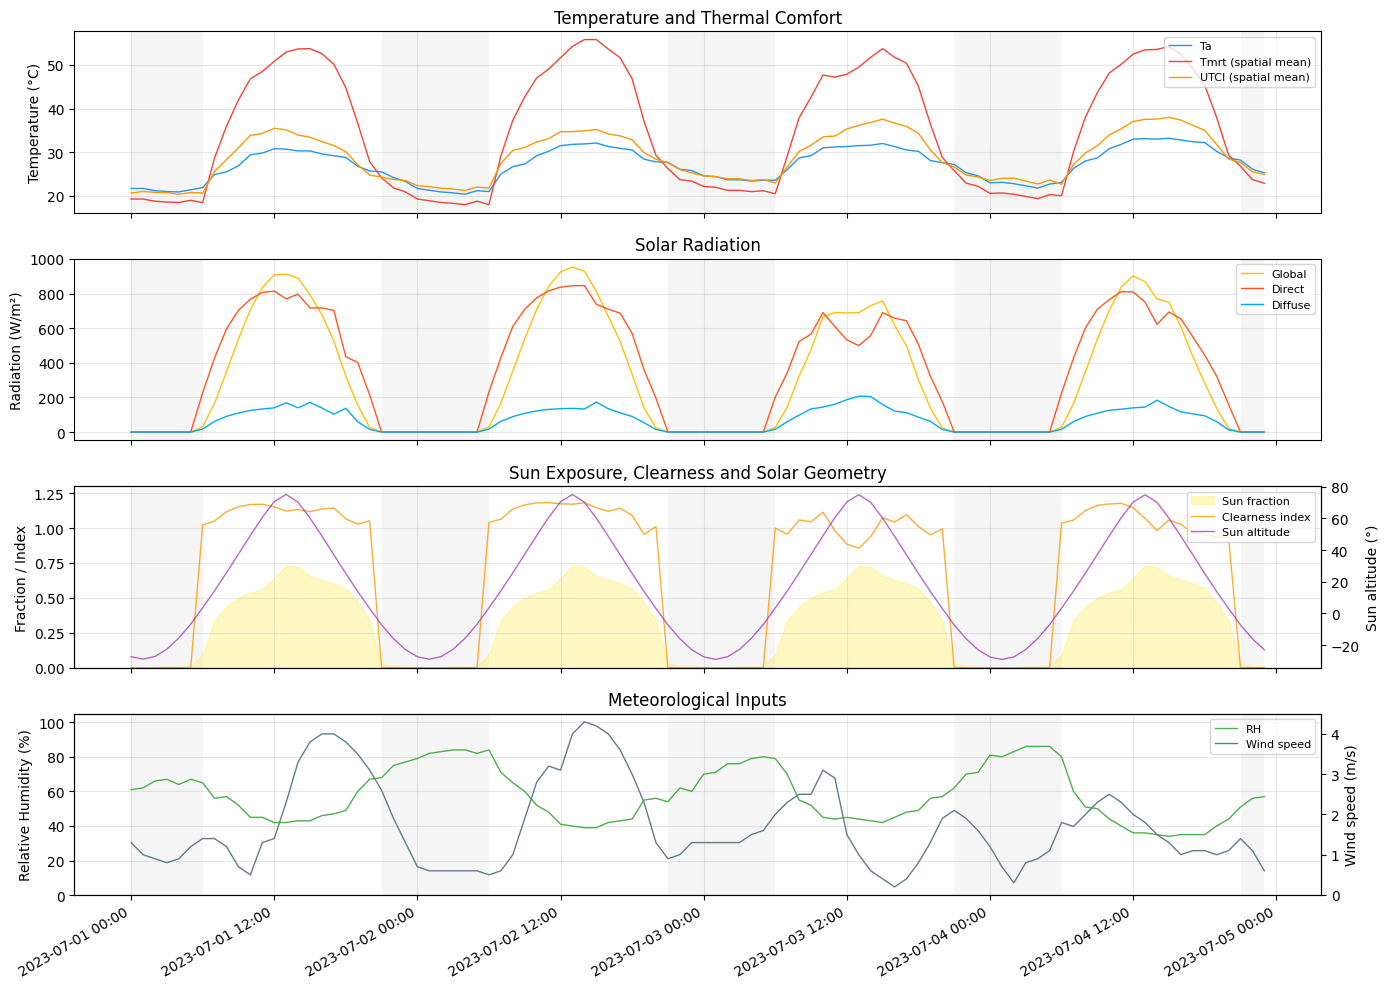

In [7]:
summary.plot()

## 6. Summary grids

The summary also contains spatial grids aggregated over all timesteps: mean/max/min Tmrt,
mean UTCI, sun hours, and hours above UTCI thresholds.


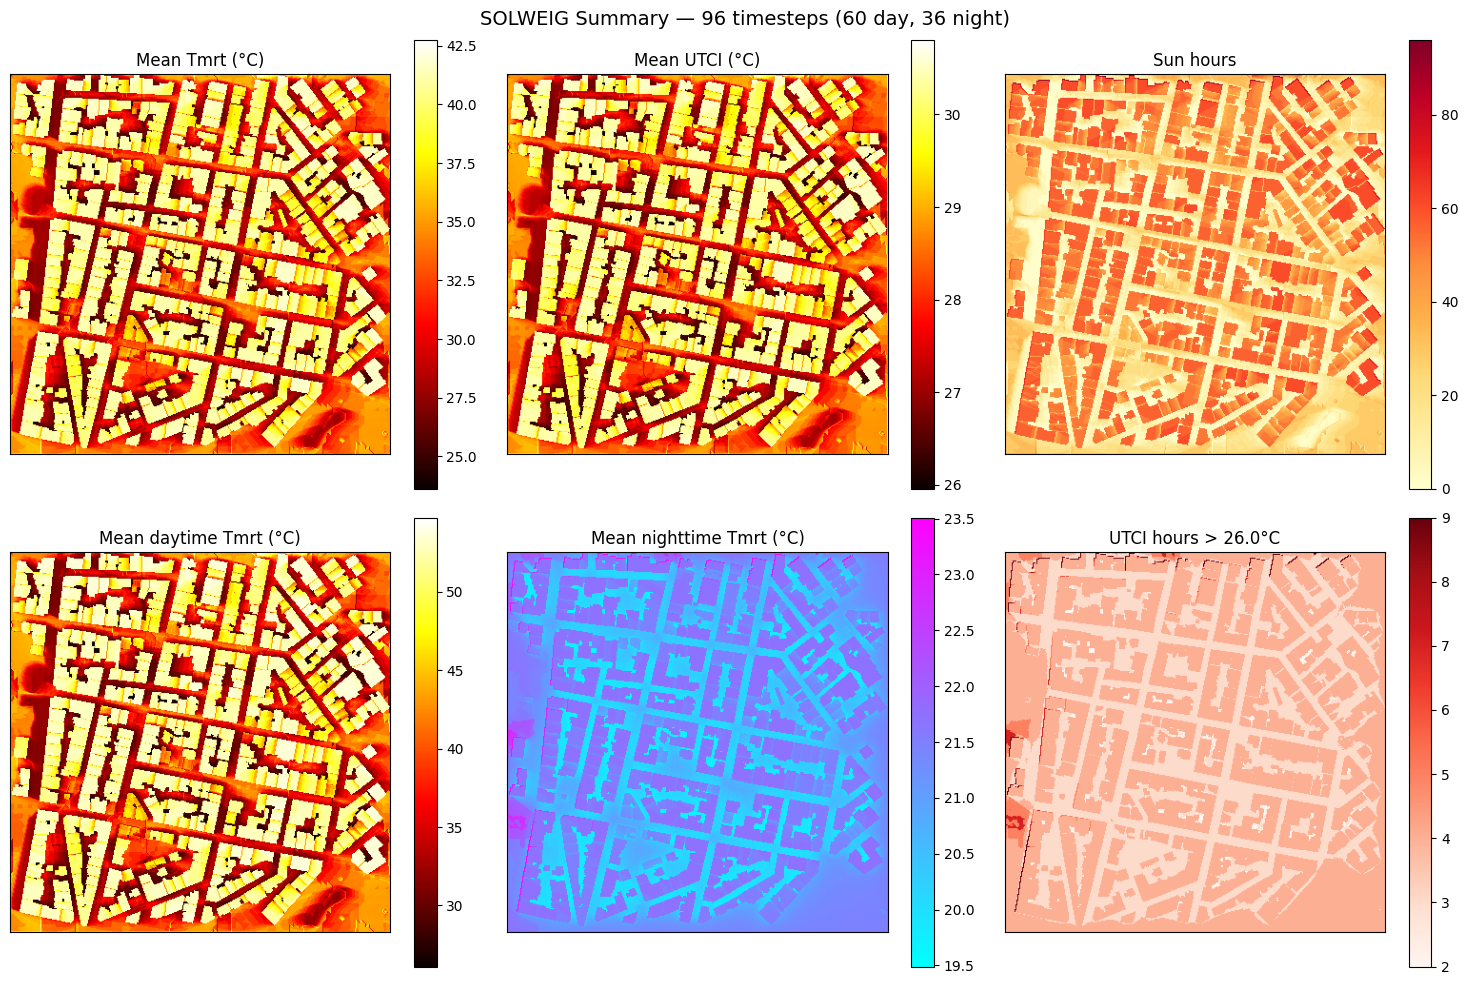

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

im0 = axes[0, 0].imshow(summary.tmrt_mean, cmap="hot")
axes[0, 0].set_title("Mean Tmrt (°C)")
plt.colorbar(im0, ax=axes[0, 0])

im1 = axes[0, 1].imshow(summary.utci_mean, cmap="hot")
axes[0, 1].set_title("Mean UTCI (°C)")
plt.colorbar(im1, ax=axes[0, 1])

im2 = axes[0, 2].imshow(summary.sun_hours, cmap="YlOrRd")
axes[0, 2].set_title("Sun hours")
plt.colorbar(im2, ax=axes[0, 2])

im3 = axes[1, 0].imshow(summary.tmrt_day_mean, cmap="hot")
axes[1, 0].set_title("Mean daytime Tmrt (°C)")
plt.colorbar(im3, ax=axes[1, 0])

im4 = axes[1, 1].imshow(summary.tmrt_night_mean, cmap="cool")
axes[1, 1].set_title("Mean nighttime Tmrt (°C)")
plt.colorbar(im4, ax=axes[1, 1])

# Show hours above the first UTCI threshold
threshold = sorted(summary.utci_hours_above.keys())[0]
im5 = axes[1, 2].imshow(summary.utci_hours_above[threshold], cmap="Reds")
axes[1, 2].set_title(f"UTCI hours > {threshold}°C")
plt.colorbar(im5, ax=axes[1, 2])

for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle(
    f"SOLWEIG Summary — {len(summary)} timesteps ({summary.n_daytime} day, {summary.n_nighttime} night)",
    fontsize=14,
)
plt.tight_layout()
plt.show()

## 7. Custom timeseries charts

The `summary.timeseries` object contains 1-D arrays of spatial means at each timestep.
You can use these to build any custom chart.


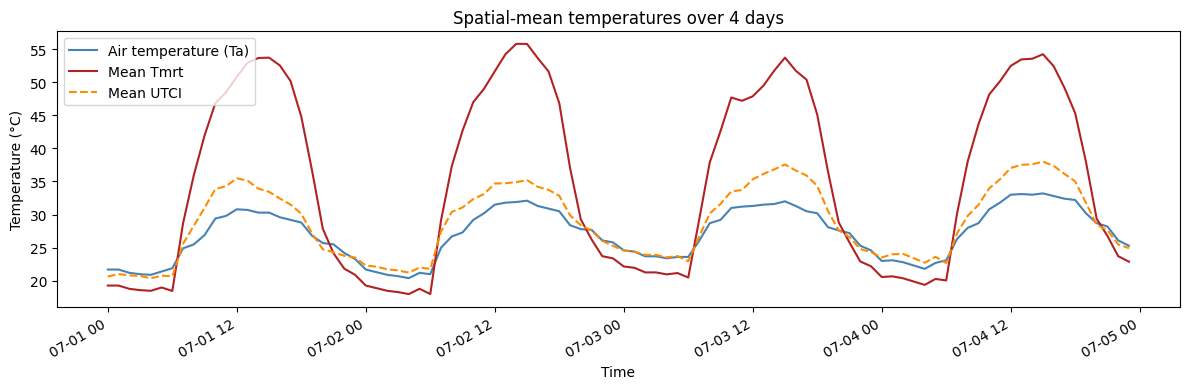

In [9]:
ts = summary.timeseries

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(ts.datetime, ts.ta, label="Air temperature (Ta)", color="steelblue")
ax.plot(ts.datetime, ts.tmrt_mean, label="Mean Tmrt", color="firebrick")
ax.plot(ts.datetime, ts.utci_mean, label="Mean UTCI", color="darkorange", linestyle="--")
ax.set_ylabel("Temperature (°C)")
ax.set_xlabel("Time")
ax.legend()
ax.set_title("Spatial-mean temperatures over 4 days")
fig.autofmt_xdate()
plt.tight_layout()
plt.show()